<div align="right">Python 2.7 Jupyter Notebook</div>

# Geotagging WiFi access points

<div class="alert alert-warning">
**This notebook contains advanced exercises that are only applicable to students who wish to deepen their understanding and qualify for bonus marks on this course.** You will be able to achieve 100% for this notebook by successfully completing exercise 1. An optional, additional exercise can be completed to qualify for bonus marks.
</div>

### Your completion of the notebook exercises will be graded based on your ability to do the following: 

**All students**:

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?


**Advanced students**:

> **Apply**: Are you able to execute code (using the supplied examples) that performs the required functionality on supplied or generated data sets? 

> **Analyze**: Are you able to pick the relevant method or library to resolve specific stated questions?

> **Create**: Are you able to produce notebooks that serve as computational record of a session, and can be used to share your insights with others? 

#### Notebook objectives
By the end of this notebook you will be expected to understand and apply the steps involved in geotagging, which are the following:
> 1. Match the records in time.
2. Compute the median location of each access point (AP).
3. Filter out the non-stationary routers.
 
####  List of exercises
>   - **Exercise 1**: Identification of stationary WiFi routers.
  - **Exercise 2 [Advanced]**: Identification of non-stationary WiFi routers.

# Notebook introduction

This notebook will use the same Dartmouth StudentLife data set, as in previous exercises. In this exercise, you will combine WiFi scans with location information to create a small database of WiFi access point (AP) locations, using Google's location services. You will be replicating the work of Piotr Sapieżyński et al. (2015).

You will start by importing the necessary modules and variable definitions.

<div class="alert alert-warning">
<b>Note</b>:<br>
It is strongly recommended that you save and checkpoint after applying significant changes or completing exercises. This allows you to return the notebook to a previous state should you wish to do so. On the Jupyter menu, select "File", then "Save and Checkpoint" from the dropdown menu that appears.
</div>

#### Load libraries and set options

In order to compute the median and calculate the distances in Section 1.4.2, you will need to import the custom function from the "utils” directory.

In [1]:
# Load relevant libraries.
from os import path
import pandas as pd
import numpy as np
import folium
import glob
from tqdm import tqdm
%matplotlib inline

# Load custom modules.
import sys
sys.path.append('..')
from utils import getmedian, haversine
from utils import llaToECEF as coords_to_geomedian
from utils import ECEFTolla as geomedian_to_coords

from IPython.display import Image

In [2]:
# Define variable definitions.
wifi_path     = '../data/dartmouth/wifi'
location_path = '../data/dartmouth/location/'

## 1. Single user review
For simplicity, review a single user's data, examine the properties of that data, and try to see if analysis yields any results of value. You should be familiar with both WiFi and location data, from previous exercises. As a result, they will be loaded and presented without extensive clarification.

#### 1.1 Data exploration

In [3]:
# Load WiFi data.
u00_wifi = pd.read_csv(path.join(wifi_path, 'wifi_u00.csv')) 
u00_wifi.head(3)

,time,BSSID,freq,level
0,1364356963,00:60:b3:07:1d:27,2427,-90
1,1364356963,f8:1e:df:fd:4a:4b,2417,-64
2,1364358163,f8:1e:df:fd:4a:4b,2417,-69


In [4]:
# Load location data.
u00_loc = pd.read_csv(path.join(location_path, 'gps_u00.csv'))
u00_loc.head(3)

,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
0,1364356963,network,wifi,24.0,43.759135,-72.329240,0.000000,0.0,0.0,stationary
1,1364358144,gps,NaN,22.0,43.759503,-72.329018,250.899994,0.0,0.0,NaN
2,1364359364,network,wifi,23.0,43.759134,-72.329238,0.000000,0.0,0.0,stationary


#### 1.2 Remove the columns that you do not require

In [5]:
# Remove columns from WiFi dataset.
u00_wifi.drop(['freq', 'level'], axis=1, inplace=True)
u00_wifi.head(3)

,time,BSSID
0,1364356963,00:60:b3:07:1d:27
1,1364356963,f8:1e:df:fd:4a:4b
2,1364358163,f8:1e:df:fd:4a:4b


In [6]:
# Remove columns from location dataset.
u00_loc.drop(['provider', 'network_type', 'bearing', 'speed', 'travelstate'], axis=1, inplace=True)
u00_loc.head(3)

,time,accuracy,latitude,longitude,altitude
0,1364356963,24.0,43.759135,-72.329240,0.000000
1,1364358144,22.0,43.759503,-72.329018,250.899994
2,1364359364,23.0,43.759134,-72.329238,0.000000


#### 1.3 Remove location records with poor accuracy
The accuracy reported in location records is interpreted counterintuitively. The higher the value, the less accurate the measurement. It denotes the radius of a circle within which 68% of the measurements (or one standard deviation) of the reported coordinates are present. Since the radius of an outdoor access point can reach 250 metres  (Sapiezynski et al. 2015), it is safe to assume a more conservative measure of 200 metres (at an elevated risk of classifying routers as non-stationary).

The accuracy of location measurements is a major source of noise, hence the need for additional consideration. To do that,  you need to plot the cumulative distribution of the accuracy.

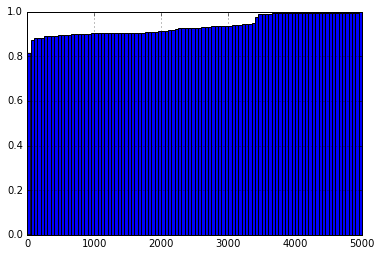

In [7]:
# Plot histogram of accuracy observations.
u00_loc.accuracy.hist(cumulative=True, normed=1, bins=100)

It looks like the data set contains quite accurate location measurements, as a visual inspection of the histogram suggests that almost 90% of the observations have relatively good accuracy. It is therefore safe to select only the most accurate observations.

Using the Pandas "describe" function, you can get a quick view of the data set.

In [8]:
# Review the dataset with Pandas decribe function.
u00_loc.accuracy.describe()

count    4316.000000
mean      341.247721
std       948.196821
min         3.000000
25%        22.000000
50%        30.000000
75%        40.500000
max      5000.000000
Name: accuracy, dtype: float64

Next, determine how many observations to keep. The impact of using an accuracy value of 40 is demonstrated in the cell below.

In [9]:
# Determine the number of records meeting our threshold of 40 for accuracy.
result = len(u00_loc[u00_loc.accuracy <= 40]) / float(len(u00_loc))
print('Proportion of records that meet the criteria is {:.1f}%'.format(100*result))

Proportion of records that meet the criteria is 73.2%


73% of the records meet your criteria, and will be used as a filter in subsequent steps.

In [10]:
# Make a copy of the original dataset before applying the filter.
u00_loc_raw = u00_loc.copy()

# Apply the filter.
u00_loc = u00_loc[u00_loc['accuracy'] <= 40]

# Get the lenghts of each of the data objects.
original_location_count = len(u00_loc_raw)
filtered_location_count = len(u00_loc)

print("Number of location observations before filtering: {}".format(original_location_count)) 
print("Number of observations remaining after filtering: {}".format(filtered_location_count))

Number of location observations before filtering: 4316
Number of observations remaining after filtering: 3158


Drop the accuracy column from the DataFrame, as it is no longer required.

In [11]:
# Update the object to remove accuracy.
u00_loc.drop('accuracy', axis=1, inplace=True)

# Display the head of the new dataset.
u00_loc.head(3)

,time,latitude,longitude,altitude
0,1364356963,43.759135,-72.329240,0.000000
1,1364358144,43.759503,-72.329018,250.899994
2,1364359364,43.759134,-72.329238,0.000000


> **Note**:

> For certain methods, Pandas has the option of applying changes to data sets "inplace". While convenient, you will no longer be able to re-execute earlier cells and this feature should be used with care. The guiding principle is that you can use this feature in data cleaning and wrangling steps, where you no longer need to go back and revisit earlier steps.

> Should you need to revisit earlier steps, you can either restart the notebook and execute all the cells up to that point, or only execute the cells needed to get the object in the required form to continue your analysis.

#### 1.4 Geotagging

In order to geotag, location and WiFi readouts need to be matched based on the time of the observations. As in the paper by Sapiezynski et al. (2015),  readouts will be constrained to those happening at exactly the same second, to reduce impact of readouts from moving vehicles.

There are three steps involved in geotagging:
1. Match the records in time.
2. Compute the median location of each AP.
3. Filter out the non-stationary routers.

These three steps will be explored in further detail in the following sections of this notebook.

#### 1.4.1 Match the records 
This requires the use of Pandas magic to join (much like SQL's join) the DataFrames based on time. First, use the time as the index with the "`df.set_index()`" method, and then join them with the "`df.join()`" method.

In [12]:
# Set the index for WiFi.
u00_wifi = u00_wifi.set_index('time')
u00_wifi.head(3)

,BSSID
time,
1364356963,00:60:b3:07:1d:27
1364356963,f8:1e:df:fd:4a:4b
1364358163,f8:1e:df:fd:4a:4b


In [13]:
# Set the index for location.
u00_loc = u00_loc.set_index('time')
u00_loc.head(3)

,latitude,longitude,altitude
time,,,
1364356963,43.759135,-72.329240,0.000000
1364358144,43.759503,-72.329018,250.899994
1364359364,43.759134,-72.329238,0.000000


Having two DataFrames with time as an index, you can simply "join" them.
> A [JOIN clause](http://pandas.pydata.org/pandas-docs/stable/merging.html) is used to merge DataFrames by combining rows from two or more tables, based on a common field between them. The most common type  of join is an "inner join". An "inner join" between two tables (A and B) returns all rows from A and B, where the join condition is met. That is, the intersection of the two tables.

<img src="innerjoin.png" alt="Drawing" style="width: 800px;"/>

In [14]:
# Join the two data sets and display the head of the new dataset.
u00_raw_geotags = u00_wifi.join(u00_loc, how='inner')
print('{} WiFi records found time matching location records.'.format(len(u00_raw_geotags)))
u00_raw_geotags.head(3)

7493 WiFi records found time matching location records.


,BSSID,latitude,longitude,altitude
time,,,,
1364356963,00:60:b3:07:1d:27,43.759135,-72.329240,0.0
1364356963,f8:1e:df:fd:4a:4b,43.759135,-72.329240,0.0
1364359364,f8:1e:df:fd:4a:4b,43.759134,-72.329238,0.0


It is time to account for possible noise, and remove the routers with sparse data (i.e., less than five observations, as in the referenced paper). Pandas "df.groupby()" will be used to do this.

In [15]:
# Create object u00_groups.
u00_groups = u00_raw_geotags.groupby('BSSID')

# Create a new object where filter criteria is met.
u00_geotags = u00_groups.filter(lambda gr: len(gr)>=5)

print("{} geotagged records remained after trimming for sparse data.".format(len(u00_geotags)))
print("They correspond to {} unique router APs".format(len(u00_groups)))

6256 geotagged records remained after trimming for sparse data.
They correspond to 1048 unique router APs


#### 1.4.2 Compute the median location of each AP
**Define stationary routers** as ones for which 95% of observations fall inside a radius of 200 metres from the geometric median of all of the observations. In order to compute the median and calculate the distances, you will need to import the custom function from the "utils” directory.

In order to compute the geometric medians with the tools at your disposal, the "`getmedian()`" method needs properly-formatted data. That means a lot of list points, where each point is an array of "longitude", "latitude", and "altitude". The algorithm accepts input in degrees as units.

In [16]:
# Create a new DataFrame with latitude and longitude.
u00_geo_medians = pd.DataFrame(columns=[u'latitude', u'longitude'])

# Transform the data set using the provided set of utilities.
for (BSSID, geotags) in u00_groups:
    
    geotags = [row for row in np.array(geotags[['latitude', 'longitude', 'altitude']])]
    geotags = [coords_to_geomedian(row) for row in geotags]
    
    median  = getmedian(geotags)
    median  = geomedian_to_coords(median)[:2]
    
    u00_geo_medians.loc[BSSID] = median

After completing the above, you will have your geomedians, and will be ready to move on to the last step, which is to filter out the non-stationary access points.

In [17]:
# Display the head of the geomedians object.
u00_geo_medians.head(3)

,latitude,longitude
00:01:36:57:be:87,43.706664,-72.287212
00:01:36:57:be:88,43.706641,-72.287126
00:02:2d:9d:ee:5d,38.898938,-77.039681


#### 1.4.3 Filter out the non-stationary routers
**Identify stationary routers** with 95% confidence, and a distance threshold of 200 metres. Start by computing the distances using the "`haversine()`" function.

In [18]:
# Calculate the distances from the median.
u00_distances = {}
for BSSID, geotags in u00_groups:
    u00_distances[BSSID] = []
    (lat_median, lon_median) = u00_geo_medians.loc[BSSID]
    for (lat, lon) in np.array(geotags[['latitude','longitude']]):  
        u00_distances[BSSID].append(haversine(lon, lat, lon_median, lat_median)*1000) # haversine() returns distance in [km]

Now, check how many of the routers pass the threshold. Iterate over the access points, and count the ratio of measurements outside the threshold to all measurements. They are assigned to "static" or "others" based on your confidence level.

In [19]:
# Group access points as static or non-static.
# Set the thresholds.
distance_threshold = 200
confidence_level    = 0.95

# Create empty lists.
static = []
others = []

for BSSID, distances in u00_distances.items():
    
    all_count  = len(distances)
    near_count = len(filter(lambda distance: distance <= distance_threshold, distances))
    
    if( near_count / all_count >= confidence_level ):
        static.append(BSSID)
    else:
        others.append(BSSID)

# Print summary results.
print ("We identified {} static routers and {} non-static (moved or mobile).".format(len(static), len(others))) 

We identified 1045 static routers and 3 non-static (moved or mobile).


The tagged routers (access points) can now be visualized on a map.

In [20]:
# Plot the access points on a map.
map_center  = list(u00_geo_medians.median())
routers_map = folium.Map(location=map_center, zoom_start=14)
# Add points to the map for each of the locations.
for router in static:
      folium.CircleMarker(u00_geo_medians.loc[router], fill_color='red', radius=15, fill_opacity=0.5).add_to(routers_map)

#Display the map.
routers_map

> **Note**:

> In order to validate your results, you can perform a "rough" check of validity by using the Google location API, which utilizes their own WiFi positioning. Set "bssid1" and "bssid2" to actual MAC addresses of two routers located near each other to determine the location of a user.

In [21]:
# Import additional library and set access points to review.
import requests
bssid1 = '00:01:36:57:be:88'
bssid2 = '00:01:36:57:be:87'

# Use the Google API to return the geocoded location of the user location.
url = 'https://maps.googleapis.com/maps/api/browserlocation/json?browser=' \
            'chrome&sensor=true&wifi=mac:{}&wifi=mac:{}'.format(bssid1, bssid2)

# Save the response of the API call.
response = requests.post(url)

# Print the response.
print(response.json()['location'])

{u'lat': 43.7068263, u'lng': -72.2868704}


You can now compare this to your computed values.

In [22]:
u00_geo_medians.loc[[bssid1, bssid2]]

,latitude,longitude
00:01:36:57:be:88,43.706641,-72.287126
00:01:36:57:be:87,43.706664,-72.287212


The results are acceptable. You can compute the actual distance between the points with the "haversine" function.

In [23]:
# Calculate and display the difference between calculated and Google API provided locations.
lat_m1, lon_m1 = u00_geo_medians.loc[bssid1]
lat_m2, lon_m2 = u00_geo_medians.loc[bssid2]

lat, lon = response.json()['location'].values()

print('Distance from the Google API provided location to our first router ' \
            'estimation is {:2g}m'.format(haversine(lon,lat,lon_m1,lat_m1)*1000))
print('Distance from the Google API provided location to our first router ' \
            'estimation is {:2g}m'.format(haversine(lon,lat,lon_m2,lat_m2)*1000))

Distance from the Google API provided location to our first router estimation is 29.0871m
Distance from the Google API provided location to our first router estimation is 32.8753m


## 2. Review of all users
Next, repeat the analysis from the previous section for all users. This analysis will be used in the next exercise.

<br>
<div class="alert alert-warning">
<b>Important:</b>
Please ensure that this is the only running notebook when performing this section, because you will require as many resources as possible to complete the next section. In the Orientation Module, you were introduced to the process required to shut down notebooks. That being said, you can shut down running notebooks by viewing the "Running" tab on your Jupyter Notebook directory view.
</div>

> **Note**:

> There will be less contextual information provided in this section, as the details have already been provided in Section 1 of this notebook

#### 2.1 Load data for all users
This section utilizes two new libraries that do not fall within the scope of this course. Interested students can read more about [glob](https://docs.python.org/2.7/library/glob.html),  which is used to read files in the specified directory, and [tqdm](https://github.com/tqdm/tqdm), which is  used to render a progress bar. Set your variables, then create the required function to process the input files, and finally, execute this function to process all the files.

> **Note**:

> Processing a large amount of files or records can be time consuming. It is good practice to include progress bars to provide visual feedback where applicable.

In [24]:
# Set variables.
all_geotags = pd.DataFrame(columns=['time','BSSID','latitude','longitude','altitude'])
all_geotags = all_geotags.set_index('time')
pcounter = 0

In [25]:
# Define function to build the dataset, all_geotags, using the input files supplied.
def build_ds(file_in, all_geotags):

    # Get the user id.
    user_id = path.basename(file_in)[5:-4]

    # Read the WiFi and location data for the user.
    wifi = pd.read_csv(file_in)
    loc  = pd.read_csv(path.join(location_path, 'gps_'+user_id+'.csv'))

    # Filter location data not meeting the accuracy threshold.
    loc = loc[loc.accuracy <= 40]

    # Drop the columns not required.
    wifi.drop(['freq', 'level'], axis=1, inplace=True)
    loc.drop(['accuracy', 'provider', 'network_type', 'bearing', 'speed', 'travelstate'], axis=1, inplace=True)

    # Index the datasets based on time.
    loc  = loc.set_index('time')
    wifi = wifi.set_index('time')

    # Join the datasets based on time index.
    raw_tags = wifi.join(loc, how='inner')

    # Return the dataset for the user.
    return [raw_tags]

In [26]:
# Iterate through the files in the specified directory and append the results of the function to the all_geotags variable.
for f in tqdm(glob.glob(wifi_path + '/*.csv')):
    # Append result from our function to all_geotags for each input file supplied.
    all_geotags = all_geotags.append(build_ds(f, all_geotags))

100%|██████████| 49/49 [01:02<00:00,  1.24s/it]


#### 2.2 Drop APs with sparse records
Remove access points with less than five observations.

In [27]:
print ("{} all geotags found".format(len(all_geotags)))

all_groups = all_geotags.groupby('BSSID')
print ("{} unique routers found".format(len(all_groups)))

# Drop sparsely populated access points.
all_geotags = all_groups.filter(lambda gr: len(gr)>=5)
all_groups = all_geotags.groupby('BSSID')

print ("{} unique router APs remaining after dropping routers with sparse data".format(len(all_groups)))    

673358 all geotags found
9790 unique routers found
4943 unique router APs remaining after dropping routers with sparse data


#### 2.3 Compute medians
Compute the medians for each router in the combined data set, as per Section 1.4.2.

In [28]:
# Create a new variable containing all the coordinates.
all_geo_medians = pd.DataFrame(columns=[u'latitude', u'longitude'])

# Compute the geomedians and add to all_geo_medians.

# Initiate progress bar.
with tqdm(total=len(all_groups)) as pbar:
    # Iterate through data in all_groups as per single user example.
    for i, data in enumerate(all_groups):
        (BSSID, geotags) = data

        geotags = [row for row in np.array(geotags[['latitude', 'longitude', 'altitude']])]
        geotags = [coords_to_geomedian(row) for row in geotags]

        median  = getmedian(geotags)
        median  = geomedian_to_coords(median)[:2]

        all_geo_medians.loc[BSSID] = median
        pbar.update()
    pbar.close()

100%|██████████| 4943/4943 [01:57<00:00, 42.23it/s]


#### 2.4 Compute distances of observations to the calculated median
Compute the distance from the medians for each router in the combined dataset.

In [29]:
# Calculate the distances from the median.
all_distances = {}

# Initiate progress bar.
with tqdm(total=len(all_groups)) as pbar:
    # Iterate through data in all_groups as per single user example.
    for i, data in enumerate(all_groups):
        (BSSID, geotags) = data
        all_distances[BSSID] = []
        (lat_median, lon_median) = all_geo_medians.loc[BSSID]
        for (lat, lon) in np.array(geotags[['latitude','longitude']]):  
            all_distances[BSSID].append(haversine(lon, lat, lon_median, lat_median)*1000)
        pbar.update()
    pbar.close()

100%|██████████| 4943/4943 [00:41<00:00, 119.45it/s]


#### 2.5 Label APs as static or non-static

In [30]:
# Group access points as static or non-static.
# Set the thresholds.
distance_threshold = 200
confidence_level   = 0.95

# Create empty lists.
all_static = []
all_others = []

for BSSID, distances in all_distances.items():
    
    all_count  = len(distances)
    near_count = len(filter(lambda distance: distance <= distance_threshold, distances))
    
    if( near_count / all_count >= confidence_level ):
        all_static.append(BSSID)
    else:
        all_others.append(BSSID)

# Print summary results.
print ("We identified {} static routers and {} non-static (moved or mobile).".format(len(all_static), len(all_others))) 

We identified 4465 static routers and 478 non-static (moved or mobile).


#### 2.6 Plot the static APs

In [31]:
# Plot the access points on a map.
all_map_center  = list(all_geo_medians.median())
all_routers_map = folium.Map(location=all_map_center, zoom_start=10)
# Add points to the map for each of the locations.
for router in all_static:
      folium.CircleMarker(all_geo_medians.loc[router], fill_color='red', radius=15, fill_opacity=0.5).add_to(all_routers_map)

#Display the map.
all_routers_map

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions

> Review the visual output produced for all users. Try to find a static router located outside North America. Remember that you can scroll and zoom on the map.

>**Question**: Are you able to locate a static router located outside North America? If so, where? 

There is a static router in london. More specifically, the cluster appears to be located on Midland Road near the British Library and some shops/cafes. 

<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 2 [Advanced] Start.</b>
</div>

> <div class="alert alert-warning">
<b>Note</b>:<br>
This activity is for advanced students only and extra credit will be allocated. Students will not be penalized for not completing this activity.
</div>

### Instructions

> Can you identify moving BSSIDs and plot the observed locations on a map?

> This is not a trivial task (compared to geotagging stationary routers) and there are many possible ways to perform the analysis.

> Input : All data points for an access point. 

> Output: Boolean mobility status.  
    
> 1. Perform agglomerative clustering. (This is not covered in the scope of this course.)
> 2. Discard clusters with n<5 observations as noise.
> 3. Compare pairwise timeframes in which each of the clusters were observed. 
> 4. If at least two clusters overlap (in time), consider the AP as mobile.
    
> **Note**:

> Keep in mind that other, possibly better, solutions exist, and you are encouraged to provide your input.

> **Hints**:

> You can start by reviewing [SciPy](https://www.scipy.org/).

> - `from scipy.spatial.distance import pdist`

> - `from scipy.cluster.hierarchy import linkage, fcluster`

In [ ]:
# Your answer here.
#  Please add as many cells as you require in this section.

In [ ]:
# Your plot here.

<br>
<div class="alert alert-info">
<b>Exercise 2 [Advanced] End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

> It is strongly recommended that you select "Close and Halt" when you have completed this notebook, to ensure that it does not continue to consume available resources.

## 3. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the Online Campus.

## 4. References
Sapieżyński, Piotr, Radu Gatej, Alan Mislove, and Sune Lehmann. 2015. “Opportunities and Challenges in Crowdsourced Wardriving.” Proceedings of the 2015 ACM Conference on Internet Measurement Conference.